<h2><b> GAME ENVIRONMENT CODE & BASIC FUNCTIONS</b></h2>

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time 

from game import Game
from racing_env import RaceGameEnv
from PIL import Image
from io import BytesIO
from tf_agents.environments import utils
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common
from tf_agents.environments import tf_py_environment
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

In [2]:
#game = Game()

for i in range(1):

    img = game.takess()
    print(img.shape)
    im = Image.fromarray(img, 'RGB')    
    imgplot = plt.imshow(im,cmap=plt.cm.binary)
    #plt.show()

    #im.save("screenshot.jpeg")
    game.getSpead()
    game.move('up')

game.resetGame()

<h2><b> TENSORFLOW ENVIRONMENT CODE </b></h2>

In [3]:
env = RaceGameEnv()
#env = tf_py_environment.TFPyEnvironment(env)
#utils.validate_py_environment(env, episodes=1)

serving at port 8000
127.0.0.1 - - [24/Jun/2020 17:53:37] "GET /v4.final.noCars.html HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2020 17:53:37] "GET /common.css HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2020 17:53:37] "GET /stats.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2020 17:53:37] "GET /common.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2020 17:53:37] "GET /music/racer.ogg HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2020 17:53:37] "GET /images/mute.png HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2020 17:53:38] "GET /images/background.png HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2020 17:53:38] "GET /images/sprites.png HTTP/1.1" 200 -
INIT IS TRIGGERED


In [4]:
#utils.validate_py_environment(env, episodes=1)

In [5]:
env = tf_py_environment.TFPyEnvironment(env)

127.0.0.1 - - [24/Jun/2020 17:53:38] code 404, message File not found
127.0.0.1 - - [24/Jun/2020 17:53:38] "GET /favicon.ico HTTP/1.1" 404 -


In [6]:
num_iterations = 40 # @param {type:"integer"}

initial_collect_steps = 500  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 1000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-8  # @param {type:"number"}
log_interval = 10  # @param {type:"integer"}

num_eval_episodes = 2  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}


In [7]:
#fc_layer_params = (200,)
#fc_layer_params = [100,50] #(150,75)
fc_layer_params = [100,10] #(150,75)

##q_net = q_network.QNetwork(
#    env.observation_spec(),
#    env.action_spec(),
#    fc_layer_params=fc_layer_params)

#conv_layer_params = [( 16 , ( 3 , 3 ), 1 ), ( 16 , ( 3 , 3 ), 1 )]
conv_layer_params = [( 16 , ( 3 , 3 ), 1 )]

q_net = q_network.QNetwork(
    env.observation_spec(),
    env.action_spec(),
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)




In [8]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [9]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


In [10]:
random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(),
env.action_spec())

random_return = -999
#random_return = compute_avg_return(env, random_policy, num_eval_episodes)

env._reset()
print("Return from Random agent is " + str(random_return))

Return from Random agent is -999


In [11]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=replay_buffer_max_length)

agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [12]:
def collect_step(environment, policy, buffer):
  #start_time = time.time()
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)
  # Add trajectory to the replay buffer
  buffer.add_batch(traj)
  #print("All collect_step took %s seconds" % (time.time() - start_time))
  
def collect_data(env, policy, buffer, steps):
  for i in range(steps):
    collect_step(env, policy, buffer)

collect_data(env, random_policy, replay_buffer, steps=100)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers


Action is = 2 :: Speed is = 0 :: Reward is =-3
Action is = 2 :: Speed is = 0 :: Reward is =-3
Action is = 3 :: Speed is = 0 :: Reward is =-3
Action is = 2 :: Speed is = 0 :: Reward is =-3
Action is = 1 :: Speed is = 0 :: Reward is =-3
Action is = 3 :: Speed is = 0 :: Reward is =-3
Action is = 3 :: Speed is = 0 :: Reward is =-3
Action is = 1 :: Speed is = 0 :: Reward is =-3
Action is = 0 :: Speed is = 4 :: Reward is =2
Action is = 0 :: Speed is = 8 :: Reward is =10
Action is = 3 :: Speed is = 6 :: Reward is =6
Action is = 3 :: Speed is = 5 :: Reward is =4
Action is = 2 :: Speed is = 3 :: Reward is =2
Action is = 2 :: Speed is = 1 :: Reward is =0
Action is = 0 :: Speed is = 5 :: Reward is =6
Action is = 1 :: Speed is = 4 :: Reward is =3
Action is = 2 :: Speed is = 1 :: Reward is =-1
Action is = 0 :: Speed is = 6 :: Reward is =7
Action is = 0 :: Speed is = 8 :: Reward is =12
Action is = 2 :: Speed is = 5 :: Reward is =6
Action is = 2 :: Speed is = 3 :: Reward is =2
Action is = 3 :: Speed 

In [13]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 55, 240, 3), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float64, action=tf.int32, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [14]:
iterator = iter(dataset)

print(iterator)


In [15]:
"""
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
env._reset()
avg_return = 0
#avg_return = compute_avg_return(env, agent.policy, num_eval_episodes)
returns = [avg_return]

for i in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for j in range(collect_steps_per_iteration):
    #print("Step " + str(j))
    collect_step(env, agent.collect_policy, replay_buffer)

  env._reset()
  # Sample a batch of data from the buffer and update the agent's network.
  print("Agent training for %s th time" % str(i))
  start_time = time.time()
  for j in range(collect_steps_per_iteration):
    experience, unused_info = next(iterator)  
    
    train_loss = agent.train(experience).loss
  print("Agent trained in %s seconds" % (time.time() - start_time))
  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    env._reset()
    avg_return = compute_avg_return(env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)
"""

'\ntry:\n  %%time\nexcept:\n  pass\n\n# (Optional) Optimize by wrapping some of the code in a graph using TF function.\nagent.train = common.function(agent.train)\n\n# Reset the train step\nagent.train_step_counter.assign(0)\n\n# Evaluate the agent\'s policy once before training.\nenv._reset()\navg_return = 0\n#avg_return = compute_avg_return(env, agent.policy, num_eval_episodes)\nreturns = [avg_return]\n\nfor i in range(num_iterations):\n\n  # Collect a few steps using collect_policy and save to the replay buffer.\n  for j in range(collect_steps_per_iteration):\n    #print("Step " + str(j))\n    collect_step(env, agent.collect_policy, replay_buffer)\n\n  env._reset()\n  # Sample a batch of data from the buffer and update the agent\'s network.\n  print("Agent training for %s th time" % str(i))\n  start_time = time.time()\n  for j in range(collect_steps_per_iteration):\n    experience, unused_info = next(iterator)  \n    \n    train_loss = agent.train(experience).loss\n  print("Agent tr

In [16]:

try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = 0
#avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
train_loss_arr = []

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  start_time = time.time()
  for _ in range(collect_steps_per_iteration):
    collect_step(env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss
  #print("Agent trained in %s seconds" % (time.time() - start_time))
  train_loss_arr.append(train_loss)
  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)
#time_step = environment.reset()


Action is = 1 :: Speed is = 0 :: Reward is =-3
Action is = 1 :: Speed is = 0 :: Reward is =-3
Action is = 1 :: Speed is = 0 :: Reward is =-3
Action is = 1 :: Speed is = 0 :: Reward is =-3
Action is = 1 :: Speed is = 0 :: Reward is =-3
Action is = 1 :: Speed is = 0 :: Reward is =-3
Action is = 1 :: Speed is = 0 :: Reward is =-3
Action is = 1 :: Speed is = 0 :: Reward is =-3
step = 10: loss = 184.4656982421875
Action is = 1 :: Speed is = 0 :: Reward is =-3
Action is = 1 :: Speed is = 0 :: Reward is =-3
Action is = 1 :: Speed is = 0 :: Reward is =-3
Action is = 0 :: Speed is = 4 :: Reward is =2
Action is = 1 :: Speed is = 7 :: Reward is =9
Action is = 1 :: Speed is = 2 :: Reward is =0
Action is = 1 :: Speed is = 0 :: Reward is =-2
Action is = 1 :: Speed is = 0 :: Reward is =-2
step = 20: loss = 177.95008850097656


In [17]:
#avg_return = compute_avg_return(env, agent.collect_policy, num_eval_episodes)

#avg_return

In [18]:
#avg_return = compute_avg_return(env, agent.policy, num_eval_episodes)

#avg_return

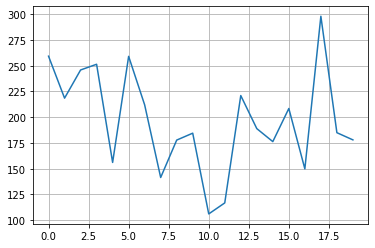

In [19]:
import matplotlib.pyplot as plt
import numpy as np


plt.plot(train_loss_arr)
plt.grid(True)
plt.show()